# Домашняя работа 3: Разработка модели детектирования объектов



##  Александров Богдан Георгиевич

На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.



Задачи домашнего задания:

 - Загрузить набор данных и визуализировать объекты. (2 балла)

 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)

 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)

 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)

 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

In [33]:
!git clone https://github.com/BogChamp/ObjectDetectionProblemFromScratch.git utils

Cloning into 'utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 10.21 KiB | 10.21 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## Описание предлагаемых исходных кодов и набора данных

- voc_dataset.py     - загружает предлагаемый набор данных, здесь также возможно выполнять аугментации над данными.

- voc_dataloader.py  - формирует порцию данных.

- prior_boxes.py     - содержит все необходимые функции для работы с `prior` боксами.

    - prior_boxes - функция генерирует `prior` боксы в соотвествии с конфигурацией

    - match       - функция решает задачу сопоставления `ground truth` боксов из набора данных и `prior` боксов

    - decode      - функция вычисляет поправки между `ground truth` боксами и `prior` боксами, собственно их будет *предсказывать* наша модель

    - encode      - функция пересчитывает `prior` боксы и *предсказанные* поправки в результирующие детектирования



- multibox_loss.py - комплексная функция потерь, решается задача сопоставления *предсказанных* и `ground truth` боксов, применяется техника `hard-negative mining`, вычисляется общая функция потерь.

In [4]:
!pip install -q gdown

In [5]:
!gdown --id 14UheyBtIByVktCsOR7OF2gBsTNGAw26E

!tar -xzf dataset.tar.gz

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14UheyBtIByVktCsOR7OF2gBsTNGAw26E
From (redirected): https://drive.google.com/uc?id=14UheyBtIByVktCsOR7OF2gBsTNGAw26E&confirm=t&uuid=eb74ebdb-39f6-4e00-b48b-2bafc58f3c87
To: /kaggle/working/dataset.tar.gz
100%|████████████████████████████████████████| 113M/113M [00:01<00:00, 85.0MB/s]

Набор данных состоит из `1528` изображений в разрешении `640x360` (тренировочная выборка - 1464 изображения, тестовая выборка - 64 изображения) в формате `VOC`. 



Набор имеет следующую структуру:



|  Директория      | Содержимое |

| ---------------- | ---------- |

| Annotations      | папка содержит разметку в виде набора файлов в формате `XML`, каждый файл содержит информацию об объектах (класс объекта, рамка объекта `xmin,ymin,xmax,ymax`)    |

| ImageSets/Main   | папка содержит два текстовых файла с распределением данных на тренирововчную `trainval.txt` и тестовую выборки `test.txt` |

| JPEGImages       | папка содержит изображения в `JPEG` формате |

## Архитектура модели на основе VGG16



Обязательно посмотрите реализацию и разберитесь в том, как устроенна модель, это будет полезно при разработке собственной модели детектирования.



![Image](output_vgg16.png)

## Архитектура модели на основе ResNet18



Можно исследовать реализацию ResNet в пакете PyTorch, это будет полезно при разработке собственного детектора.



https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py



![Image](output_resnet18.png)

In [4]:
!pip install torchview

In [41]:
import os, sys
sys.path.insert(0, 'utils')

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import glob
import cv2

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import models
from torchvision.models import VGG16_Weights, ResNet18_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, convert_image_dtype
from torchvision.io import read_image

from utils.voc_dataloader import get_train_dataloader, get_test_dataloader
from utils.voc_dataset import light_transform, medium_transform, strong_transform, VOC_CLASSES
from utils.prior_boxes import prior_boxes, detect_objects, jaccard
from utils.multibox_loss import MultiBoxLoss

In [2]:
%load_ext autoreload

%autoreload 2

## Создаем конфигурацию, которая описывает работы нашего детектора (пример для VGG16)

In [3]:
#VGG16

custom_config = {
 'num_classes'  : 2,
 'feature_maps' : [(45,80), (22,40), (11,20), (6,10), (4,8), (2,6)], #VGG16 - 640x360, размерность карт признаков, которые будут использоваться
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00], #Параметр масштаба боксов
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05], #Параметр масштаба боксов


 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]], #Список содержаший информацию о соотношении сторон для prior боксов
 'num_priors'   : [6, 6, 6, 6, 4, 4], #Число prior боксов
 'variance'     : [0.1, 0.2],
 'clip'         :    True,

 'overlap_threshold': 0.5, #Параметр IoU
 'conf_threshold'   : 0.1, #Параметр confidence
 'overlap_detect'   : 0.25,
 'neg_pos_ratio'    :   3, #Параметр hard-negative mining

 'model_name' : 'vgg16'

}

## Загружаем требуемый набор данных

In [4]:
from argparse import Namespace

param_s = Namespace(
 dataset_root_dir="./dataset",
 epochs = 20, batch_size =4,
 checkpoint = None, output = 'output',
 multistep = [10, 20], 
 learning_rate = 1e-3, momentum = 0.9, 
 weight_decay = 0.0005, warmup = None,
 num_workers = 4,
 seed = 42
)

In [5]:
train_annotation_filename = os.path.join(param_s.dataset_root_dir, "ImageSets/Main/trainval.txt" )
test_annotation_filename  = os.path.join(param_s.dataset_root_dir, "ImageSets/Main/test.txt"     )
train_dataloader          = get_train_dataloader(param_s.dataset_root_dir, train_annotation_filename, param_s.batch_size, param_s.num_workers)
test_dataloader           = get_test_dataloader (param_s.dataset_root_dir, test_annotation_filename , param_s.batch_size, param_s.num_workers)

In [6]:
batch = next(iter(test_dataloader))

In [7]:
def convert_img_back(img):
    converted_img = img * torch.Tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1) 
    converted_img += torch.Tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    return (converted_img * 255).type(torch.uint8)

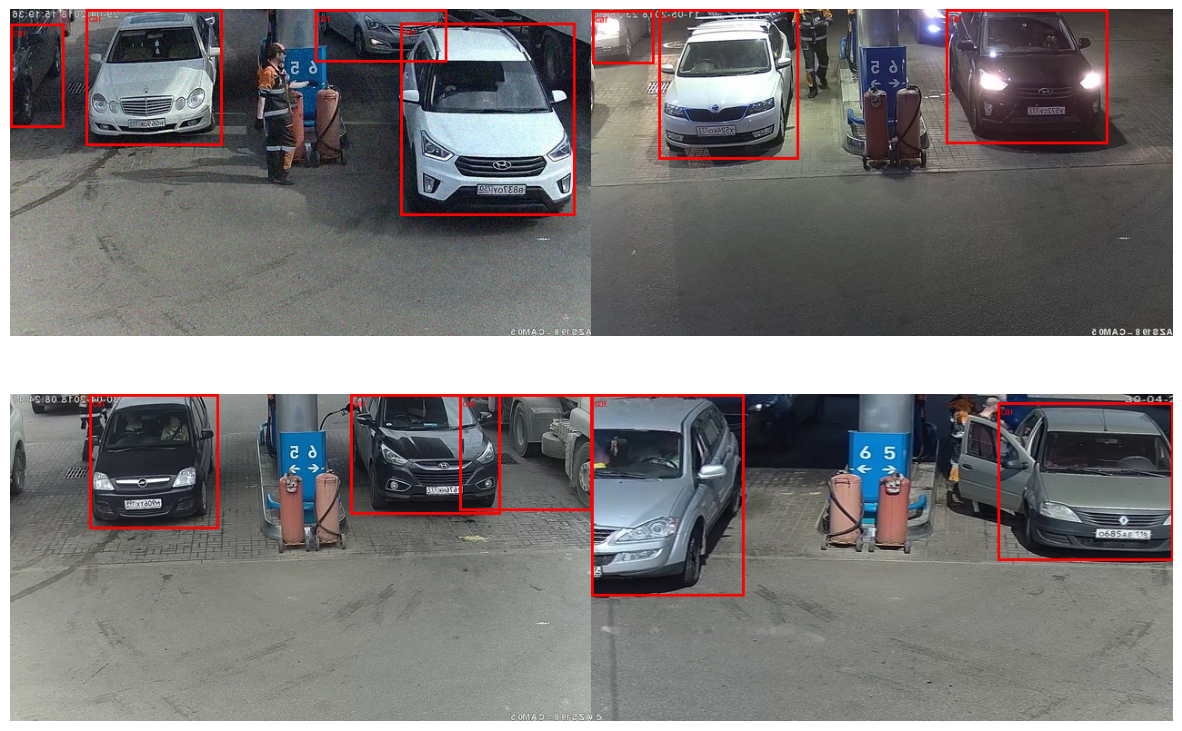

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15, 10))

for i in range(4):
    image_cpu = convert_img_back(batch[0][i])
    box_s = batch[1][i]
    label_s = batch[2][i]
    height, width = image_cpu.shape[1], image_cpu.shape[2]

    if torch.numel(box_s)>0 and torch.numel(label_s)>0:
        class_s = [VOC_CLASSES[label] for label in label_s.tolist()]
        box_s = box_s * torch.as_tensor([[width, height, width, height]])

        target_image_cpu   = draw_bounding_boxes(image_cpu, box_s, labels=class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = image_cpu.permute([1,2,0]).numpy()

    ax[i // 2][i % 2].imshow(target_image_numpy)
    ax[i // 2][i % 2].axis('off')

plt.show()   

## Разработать функцию вычисление mAP метрики задачи детектирования



В качестве примера можно использовать https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html

In [9]:
def custom_map(custom_config, gt_label_ss_all, gt_box_ss_all, 
               pred_label_ss_all, pred_box_ss_all, pred_conf_ss_all):
    ap_list = []
    num_imgs = len(gt_box_ss_all)
    for cls in range(1, custom_config["num_classes"]):
        pred_cls_conf_all = []
        cls_correct = []
        
        cls_gt_num = 0
        for i in range(num_imgs):
            pred_cls_bboxs = pred_box_ss_all[i][pred_label_ss_all[i] == cls]
            pred_cls_conf = pred_conf_ss_all[i][pred_label_ss_all[i] == cls]
            gt_cls_bboxs = gt_box_ss_all[i][gt_label_ss_all[i] == cls]

            cls_gt_num += (gt_label_ss_all[i] == cls).sum().item()
            overlaps = jaccard(gt_cls_bboxs, pred_cls_bboxs)
            correct = overlaps > custom_config['overlap_threshold']
            for j in range(correct.shape[1]):
                if correct[:, j].any():
                    gt_ind = torch.argmax(overlaps[:, j]) # вдруг наш бокс пересекает несколько gt
                    correct[:, j] = False 
                    correct[gt_ind, j] = True
                    correct[gt_ind, j+1:] = False

            pred_cls_conf_all.append(pred_cls_conf)
            cls_correct.append(correct.any(dim=0))

        ind_sorted = torch.argsort(torch.cat(pred_cls_conf_all), descending=True)
        sorted_correct = torch.cat(cls_correct)[ind_sorted]

        precision = sorted_correct.cumsum(0) / torch.arange(1, sorted_correct.shape[0] + 1)
        recall = sorted_correct.cumsum(0) / cls_gt_num
        precision_max = torch.cummax(precision.flip([0]), 0)[0].flip([0])
        ap = torch.sum((recall[1:] - recall[:-1]) * precision_max[1:]) + recall[0]

        ap_list.append(ap)

    return torch.Tensor(ap_list).mean().item()

Если мы возьмем в качестве предсказаний Ground truth, то mAP должен быть 1.

In [10]:
gt_map = custom_map(custom_config, [batch[2][0]], [batch[1][0]], [batch[2][0]], [batch[1][0]], [torch.ones_like(batch[2][0])])
print(gt_map)

1.0


Создадим искусственный пример, где модель не смогла предсказать некоторые боксы, и уверенность в них небольшая.

In [11]:
custom_gt_boxs = [                      
    torch.tensor([[0.1345, 0.0000, 0.4081, 0.4047],
        [0.6489, 0.0083, 0.9093, 0.3811],
        [0.9140, 0.0014, 0.9898, 0.1321],
        [0.0000, 0.0000, 0.2056, 0.3143],
        [0.1274, 0.6328, 0.7373, 1.0000],
        [0.6192, 0.0000, 0.7733, 0.0890]]),

    torch.tensor([[0.0241, 0.0000, 0.3525, 0.4061],
        [0.7069, 0.0000, 1.0000, 0.4687]], dtype=torch.float64)
    ] # ground truth bboxes

custom_gt_labels = [torch.ones(t.shape[0]) for t in custom_gt_boxs] # ground true labels
custom_pred_boxs = [t.clone() for t in custom_gt_boxs] # simulated predicted bboxes
custom_pred_labels = [t.clone() for t in custom_gt_labels] # simulated predicted labela

In [12]:
custom_pred_boxs[0][0] += 0.01 # TP
custom_pred_boxs[0][3] += 0.6 # FP
custom_pred_boxs[0] = torch.clamp(custom_pred_boxs[0], 0, 1)
custom_pred_boxs[1][1] -= 0.5 # FP
custom_pred_boxs[1] = torch.clamp(custom_pred_boxs[1], 0, 1)

In [13]:
custom_pred_conf = [torch.Tensor([0.7, 0.8, 0.9, 0.2, 0.6, 0.4]), torch.Tensor([0.8, 0.21])] # simulated confidences

In [14]:
custom_map(custom_config, custom_gt_labels, custom_gt_boxs,
           custom_pred_labels, custom_pred_boxs, custom_pred_conf)

0.75

Рассмотрим верный рассчет:

0.9 0.8 0.8 0.7 0.6 0.4 0.21 0.2

T   T   T   T   T   T   F    F

precisions: 1 1 1 1 1 1 6/7 6/8

recalls: 1/8 2/8 3/8 4/8 5/8 6/8 6/8 6/8

AP = 1 * 6/8 = 0.75

Рассмотрим случай, где модель ошиблась сильно, то есть очень уверенно предсказала неверный бокс.

In [15]:
custom_gt_boxs = [
    torch.tensor([[0.1345, 0.0000, 0.4081, 0.4047],
        [0.6489, 0.0083, 0.9093, 0.3811],
        [0.9140, 0.0014, 0.9898, 0.1321],
        [0.0000, 0.0000, 0.2056, 0.3143],
        [0.1274, 0.6328, 0.7373, 1.0000],
        [0.6192, 0.0000, 0.7733, 0.0890],]),

    torch.tensor([[0.0241, 0.0000, 0.3525, 0.4061],
        [0.7069, 0.0000, 1.0000, 0.4687]], dtype=torch.float64)
    ]

custom_gt_labels = [torch.ones(t.shape[0]) for t in custom_gt_boxs]
custom_pred_boxs = [t.clone() for t in custom_gt_boxs]
custom_pred_labels = [t.clone() for t in custom_gt_labels]

In [16]:
custom_pred_boxs[0][0] += 0.01 # TP
custom_pred_boxs[0][3] += 0.6 # FP
custom_pred_boxs[0] = torch.clamp(custom_pred_boxs[0], 0, 1)
custom_pred_boxs[1][1] -= 0.5 # FP
custom_pred_boxs[1] = torch.clamp(custom_pred_boxs[1], 0, 1)

In [17]:
custom_pred_boxs[0] = torch.vstack([custom_pred_boxs[0], torch.tensor([0, 0, 0.1, 0.15]).unsqueeze(0), 
                                    torch.tensor([0.5, 0.5, 0.7, 0.9]).unsqueeze(0)])
custom_pred_boxs[1] = torch.vstack([custom_pred_boxs[1], torch.tensor([0.7, 0.6, 0.82, 0.7])])

In [18]:
custom_pred_labels[0] = torch.hstack([custom_pred_labels[0], torch.tensor([1, 1])])
custom_pred_labels[1] = torch.hstack([custom_pred_labels[1], torch.tensor([1])])

In [19]:
custom_pred_conf = [torch.Tensor([0.7, 0.65, 0.5, 0.9, 0.6, 0.4, 0.63, 0.2]), torch.Tensor([0.8, 0.44, 0.1])]

In [20]:
custom_map(custom_config, custom_gt_labels, custom_gt_boxs,
           custom_pred_labels, custom_pred_boxs, custom_pred_conf)

0.543154776096344

Рассмотрим верный рассчет:

0.9 0.8 0.7 0.65 0.63 0.6 0.5 0.44 0.4 0.2 0.1

F   T   T   T    F    T   T   F    T   F   F

precisions: 0 1/2 2/3 3/4 3/5 4/6 5/7 5/8 6/9 6/10 6/11

recalls: 0 1/8 2/8 3/8 3/8 4/8 5/8 5/8 6/8 6/8 6/8

AP = 3/4 * 3/8 + 2/8 * 5/7 + 1/8 * 6/9 = 0.54315 

Функция работает корректно.

## Натренировать модель на основе VGG16

In [21]:
class L2Norm(nn.Module):
    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma      = scale or None
        self.eps        = 1e-10
        self.weight     = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps
        x = torch.div(x, norm)
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return x

class SSD_VGG16(nn.Module):
    def __init__(self, num_bboxes_s, num_labels = 2):
        super().__init__()

        self.num_bboxes_s = num_bboxes_s
        self.num_labels   = num_labels

        self.used_layer_id_s       = [21, 33, 37, 41, 45, 49] #
        self.norm_layer            = L2Norm(512, 20)

        base_layers       = self._build_base_layers ()
        extra_layers      = self._build_extra_layers()
        self.total_layers = base_layers + extra_layers

        self.conf_layers, self.loc_layers = self._build_conf_loc_layers()

    def _build_base_layers(self):
        backbone_model    = models.vgg16(weights=VGG16_Weights.DEFAULT)  #False

        base_layers = nn.ModuleList(list(backbone_model.features)[:-1])
        base_layers[16].ceil_mode = True

        pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)          
        conv6 = nn.Conv2d( 512, 1024, kernel_size=3, padding=6, dilation=6)
        relu6 = nn.ReLU(inplace=True)
        conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        relu7 = nn.ReLU(inplace=True)

        nn.init.xavier_uniform_(conv6.weight)
        nn.init.zeros_         (conv6  .bias)
        nn.init.xavier_uniform_(conv7.weight)
        nn.init.zeros_         (conv7  .bias)

        base_layers.extend( [pool5, conv6, relu6, conv7, relu7] )

        return base_layers

    def _build_extra_layers(self):
        extra_layers = []

        conv8_1  = nn.Conv2d( 1024, 256, kernel_size=1, stride=1           )
        relu8_1  = nn.ReLU(inplace=True)
        conv8_2  = nn.Conv2d( 256, 512, kernel_size=3, stride=2, padding=1)
        relu8_2  = nn.ReLU(inplace=True)
        conv9_1  = nn.Conv2d( 512, 128, kernel_size=1, stride=1           )
        relu9_1  = nn.ReLU(inplace=True)
        conv9_2  = nn.Conv2d( 128, 256, kernel_size=3, stride=2, padding=1)
        relu9_2  = nn.ReLU(inplace=True)
        conv10_1 = nn.Conv2d( 256, 128, kernel_size=1, stride=1           )
        relu10_1 = nn.ReLU(inplace=True)
        conv10_2 = nn.Conv2d( 128, 256, kernel_size=3, stride=1           )
        relu10_2 = nn.ReLU(inplace=True)
        conv11_1 = nn.Conv2d( 256, 128, kernel_size=1                     )
        relu11_1 = nn.ReLU(inplace=True)
        conv11_2 = nn.Conv2d( 128, 256, kernel_size=3, stride=1           )
        relu11_2 = nn.ReLU(inplace=True)

        nn.init.xavier_uniform_(conv8_1 .weight)
        nn.init.zeros_         (conv8_1 .bias  )
        nn.init.xavier_uniform_(conv8_2 .weight)
        nn.init.zeros_         (conv8_2 .bias  )
        nn.init.xavier_uniform_(conv9_1 .weight)
        nn.init.zeros_         (conv9_1 .bias  )
        nn.init.xavier_uniform_(conv9_2 .weight)
        nn.init.zeros_         (conv9_2 .bias  )
        nn.init.xavier_uniform_(conv10_1.weight)
        nn.init.zeros_         (conv10_1.bias  )
        nn.init.xavier_uniform_(conv10_2.weight)
        nn.init.zeros_         (conv10_2.bias  )
        nn.init.xavier_uniform_(conv11_1.weight)
        nn.init.zeros_         (conv11_1.bias  )
        nn.init.xavier_uniform_(conv11_2.weight)
        nn.init.zeros_         (conv11_2.bias  )

        extra_layers = nn.ModuleList( [conv8_1, relu8_1, conv8_2, relu8_2, conv9_1, relu9_1, 
                                       conv9_2, relu9_2, conv10_1, relu10_1, conv10_2, relu10_2, 
                                       conv11_1, relu11_1, conv11_2, relu11_2] )

        return extra_layers


    def _build_conf_loc_layers(self):
        out_channels_s = [ self.total_layers[i].out_channels for i in self.used_layer_id_s ] 

        conf_layers, loc_layers = [], []
        for i, j in enumerate(self.used_layer_id_s):
            conf_layer = nn.Conv2d( self.total_layers[j].out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
            loc_layer  = nn.Conv2d( self.total_layers[j].out_channels, self.num_bboxes_s[i] * 4              , kernel_size=3, padding=1)
            
            nn.init.xavier_uniform_(conf_layer.weight)
            nn.init.zeros_         (conf_layer  .bias)
            nn.init.xavier_uniform_(loc_layer .weight)
            nn.init.zeros_         (loc_layer   .bias)

            conf_layers += [conf_layer]
            loc_layers  += [loc_layer ]

        conf_layers = nn.ModuleList(conf_layers)
        loc_layers  = nn.ModuleList(loc_layers )

        return conf_layers, loc_layers


    def forward(self, x, verbose=False):
        source_s, loc_s, conf_s = [], [], []

        for i, current_layer in enumerate(self.total_layers, -1):
            x = current_layer(x)
            if i in self.used_layer_id_s:
                if i == 21:
                    s = self.norm_layer(x)
                else:
                    s = x
                source_s.append(s)

        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s .append(l(s).permute(0, 2, 3, 1).contiguous())

        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s  = torch.cat([o.view(o.size(0), -1) for o in loc_s ], 1)

        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s  = loc_s .view(loc_s .size(0), -1, 4              )

        return loc_s, conf_s

In [22]:
def train_process(args, custom_config, model_cls, train_dataloader, test_dataloader):
    torch.manual_seed(     args.seed)
    np.random.seed   (seed=args.seed)   

    if not os.path.exists(args.output):
        os.mkdir(args.output)

    model = model_cls(custom_config['num_priors'], custom_config['num_classes'])

    prior_box_s_cpu = prior_boxes(custom_config)
    prior_box_s_gpu = prior_box_s_cpu.cuda()

    overlap_threshold = custom_config['overlap_threshold']
    neg_pos_ratio     = custom_config['neg_pos_ratio'    ]
    variance          = custom_config['variance']

    criterion = MultiBoxLoss( overlap_threshold, neg_pos_ratio, variance)
    model    .cuda()
    criterion.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay )
    scheduler = MultiStepLR(optimizer=optimizer, milestones=args.multistep, gamma=0.2)

    best_loc_loss, best_cls_loss, best_loss = np.inf, np.inf, np.inf
    train_loss_s, eval_loss_s = [], []
    train_map_s, eval_map_s = [], []

    for epoch in tqdm(list(range(args.epochs))):
        #Train model
        pred_box_ss_all, pred_label_ss_all, pred_conf_ss_all = list(), list(), list()
        gt_box_ss_all, gt_label_ss_all = list(), list()
        train_loc_loss, train_cls_loss, train_loss = 0, 0, 0
        model.train()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(train_dataloader):
            if len(box_ss_cpu) > 0 and len(label_ss_cpu) > 0: 
                image_s_gpu  =   image_s_cpu.cuda()
                label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]
                
                gt_box_ss_all += box_ss_cpu
                gt_label_ss_all += label_ss_cpu

                pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)
                loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
                loss = loc_loss + cls_loss
                pred_conf_ss_cpu = F.softmax(pred_conf_ss_gpu, dim=2).cpu()
                pred_loc_ss_cpu  = pred_loc_ss_gpu                   .cpu()

                optimizer.zero_grad()
                loss     .backward ()
                optimizer.step     ()

                train_loc_loss += loc_loss.item()
                train_cls_loss += cls_loss.item()
                train_loss     += loss    .item()

                pred_box_ss, pred_label_ss, pred_conf_ss = detect_objects(pred_loc_ss_cpu, pred_conf_ss_cpu, 
                                                                          prior_box_s_cpu, custom_config["num_classes"], 
                                                                          custom_config["overlap_detect"], custom_config["conf_threshold"])
                pred_box_ss_all += pred_box_ss
                pred_label_ss_all += pred_label_ss
                pred_conf_ss_all += pred_conf_ss

        scheduler.step()
        train_loss_s.append(train_loss)
        
        train_map = custom_map(custom_config, gt_label_ss_all, gt_box_ss_all, pred_label_ss_all, pred_box_ss_all, pred_conf_ss_all)
        train_map_s.append(train_map)

        #Eval model
        eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
        pred_box_ss_all, pred_label_ss_all, pred_conf_ss_all = list(), list(), list()
        gt_box_ss_all, gt_label_ss_all = list(), list()
        model.eval()
        with torch.no_grad():
            for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
                if len(box_ss_cpu) > 0 and len(label_ss_cpu) > 0: 
                    image_s_gpu = image_s_cpu.cuda()
                    label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                    box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]

                    gt_box_ss_all += box_ss_cpu
                    gt_label_ss_all += label_ss_cpu
                    
                    pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)
                    loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
                    loss = loc_loss + cls_loss
                    pred_conf_ss_cpu = F.softmax(pred_conf_ss_gpu, dim=2).cpu()
                    pred_loc_ss_cpu  = pred_loc_ss_gpu                   .cpu()

                    eval_loc_loss += loc_loss.item()
                    eval_cls_loss += cls_loss.item()
                    eval_loss     += loss    .item()

                    pred_box_ss, pred_label_ss, pred_conf_ss = detect_objects(pred_loc_ss_cpu, pred_conf_ss_cpu, 
                                                                          prior_box_s_cpu, custom_config["num_classes"], 
                                                                          custom_config["overlap_detect"], custom_config["conf_threshold"])

                    pred_box_ss_all += pred_box_ss
                    pred_label_ss_all += pred_label_ss
                    pred_conf_ss_all += pred_conf_ss

        eval_loss_s.append(eval_loss)
        eval_map = custom_map(custom_config, gt_label_ss_all, gt_box_ss_all, pred_label_ss_all, pred_box_ss_all, pred_conf_ss_all)
        eval_map_s.append(eval_map)
        
        print('epoch[{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}] | map [{:.4f}/{:.4f}]'.format(epoch, scheduler.get_last_lr()[0], 
                                                                                                                                train_loc_loss, eval_loc_loss, train_cls_loss, 
                                                                                                                                eval_cls_loss, train_loss, eval_loss,
                                                                                                                                train_map, eval_map))

        if eval_loss < best_loss :
            torch.save(model.state_dict(), os.path.join(args.output, f"{custom_config['model_name']}.pth"))
            best_loc_loss, best_cls_loss, best_loss = eval_loc_loss, eval_cls_loss, eval_loss
    return model, prior_box_s_cpu, train_loss_s, eval_loss_s, train_map_s, eval_map_s

In [23]:
model, prior_box, train_loss, eval_loss, train_map, eval_map = train_process(param_s, custom_config, SSD_VGG16, train_dataloader, test_dataloader)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s]  
  0%|          | 0/20 [00:00<?, ?it/s]

epoch[0] | lr 0.00100 | loc_loss [566.55/12.95] | cls_loss [1401.77/24.83] | total_loss [1968.32/37.77] | map [0.2055/0.8495]


  5%|▌         | 1/20 [01:25<27:09, 85.78s/it]

epoch[1] | lr 0.00100 | loc_loss [248.51/8.17] | cls_loss [509.61/21.21] | total_loss [758.11/29.37] | map [0.8917/0.9086]


 10%|█         | 2/20 [02:46<24:51, 82.83s/it]

epoch[2] | lr 0.00100 | loc_loss [191.94/6.27] | cls_loss [450.02/20.37] | total_loss [641.96/26.64] | map [0.9277/0.9357]


 15%|█▌        | 3/20 [04:07<23:12, 81.89s/it]

epoch[3] | lr 0.00100 | loc_loss [161.41/6.25] | cls_loss [416.55/17.33] | total_loss [577.97/23.58] | map [0.9406/0.9560]


 25%|██▌       | 5/20 [06:48<20:16, 81.08s/it]

epoch[4] | lr 0.00100 | loc_loss [147.13/6.15] | cls_loss [391.04/18.26] | total_loss [538.17/24.41] | map [0.9506/0.9494]
epoch[5] | lr 0.00100 | loc_loss [130.93/5.41] | cls_loss [367.69/16.29] | total_loss [498.62/21.70] | map [0.9566/0.9497]


 30%|███       | 6/20 [08:09<18:53, 80.97s/it]

epoch[6] | lr 0.00100 | loc_loss [120.75/5.37] | cls_loss [349.62/15.25] | total_loss [470.37/20.62] | map [0.9655/0.9510]


 40%|████      | 8/20 [10:50<16:09, 80.81s/it]

epoch[7] | lr 0.00100 | loc_loss [113.34/5.22] | cls_loss [337.87/16.54] | total_loss [451.21/21.76] | map [0.9674/0.9631]


 45%|████▌     | 9/20 [12:10<14:47, 80.67s/it]

epoch[8] | lr 0.00100 | loc_loss [107.52/4.69] | cls_loss [335.76/16.79] | total_loss [443.28/21.48] | map [0.9658/0.9704]
epoch[9] | lr 0.00020 | loc_loss [102.90/5.01] | cls_loss [320.00/14.07] | total_loss [422.90/19.08] | map [0.9711/0.9700]


 50%|█████     | 10/20 [13:31<13:26, 80.67s/it]

epoch[10] | lr 0.00020 | loc_loss [79.16/3.30] | cls_loss [286.75/13.70] | total_loss [365.92/17.00] | map [0.9761/0.9687]


 60%|██████    | 12/20 [16:12<10:45, 80.63s/it]

epoch[11] | lr 0.00020 | loc_loss [75.59/3.79] | cls_loss [278.73/14.18] | total_loss [354.31/17.97] | map [0.9791/0.9776]


 65%|██████▌   | 13/20 [17:33<09:23, 80.56s/it]

epoch[12] | lr 0.00020 | loc_loss [76.21/3.64] | cls_loss [280.03/13.92] | total_loss [356.24/17.56] | map [0.9786/0.9666]


 70%|███████   | 14/20 [18:53<08:03, 80.51s/it]

epoch[13] | lr 0.00020 | loc_loss [74.21/3.82] | cls_loss [275.53/13.78] | total_loss [349.75/17.60] | map [0.9790/0.9766]
epoch[14] | lr 0.00020 | loc_loss [73.34/3.48] | cls_loss [273.96/13.43] | total_loss [347.30/16.91] | map [0.9786/0.9824]


 80%|████████  | 16/20 [21:35<05:22, 80.60s/it]

epoch[15] | lr 0.00020 | loc_loss [72.72/3.75] | cls_loss [273.79/14.08] | total_loss [346.52/17.83] | map [0.9795/0.9814]


 85%|████████▌ | 17/20 [22:55<04:01, 80.57s/it]

epoch[16] | lr 0.00020 | loc_loss [72.15/3.75] | cls_loss [271.33/13.67] | total_loss [343.48/17.42] | map [0.9791/0.9694]


 90%|█████████ | 18/20 [24:16<02:41, 80.57s/it]

epoch[17] | lr 0.00020 | loc_loss [71.20/3.40] | cls_loss [268.05/14.23] | total_loss [339.25/17.63] | map [0.9798/0.9759]


 95%|█████████▌| 19/20 [25:37<01:20, 80.63s/it]

epoch[18] | lr 0.00020 | loc_loss [71.69/3.62] | cls_loss [265.98/13.99] | total_loss [337.67/17.61] | map [0.9823/0.9764]


100%|██████████| 20/20 [26:57<00:00, 80.87s/it]

epoch[19] | lr 0.00004 | loc_loss [69.62/3.89] | cls_loss [266.03/13.91] | total_loss [335.64/17.79] | map [0.9784/0.9733]


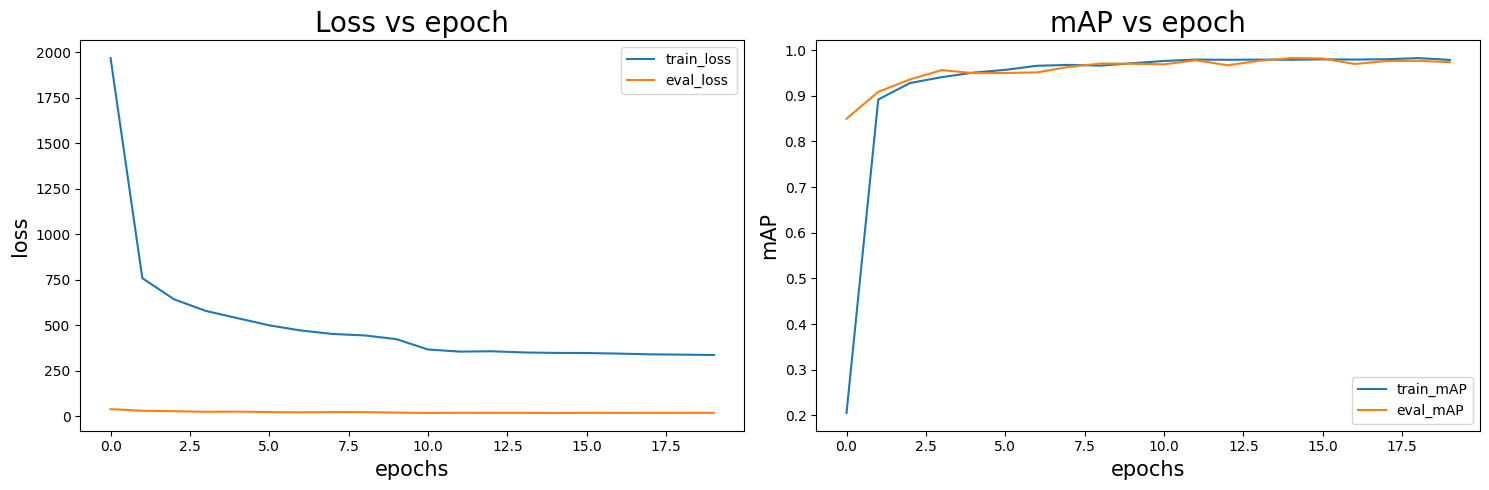

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_loss, label="train_loss")
axes[0].plot(eval_loss, label="eval_loss")
axes[0].legend()
axes[0].set_title("Loss vs epoch", fontsize=20)
axes[0].set_xlabel("epochs", fontsize=15)
axes[0].set_ylabel("loss", fontsize=15)

axes[1].plot(train_map, label="train_mAP")
axes[1].plot(eval_map, label="eval_mAP")
axes[1].legend()
axes[1].set_title("mAP vs epoch", fontsize=20)
axes[1].set_xlabel("epochs", fontsize=15)
axes[1].set_ylabel("mAP", fontsize=15)

plt.tight_layout()
plt.show()

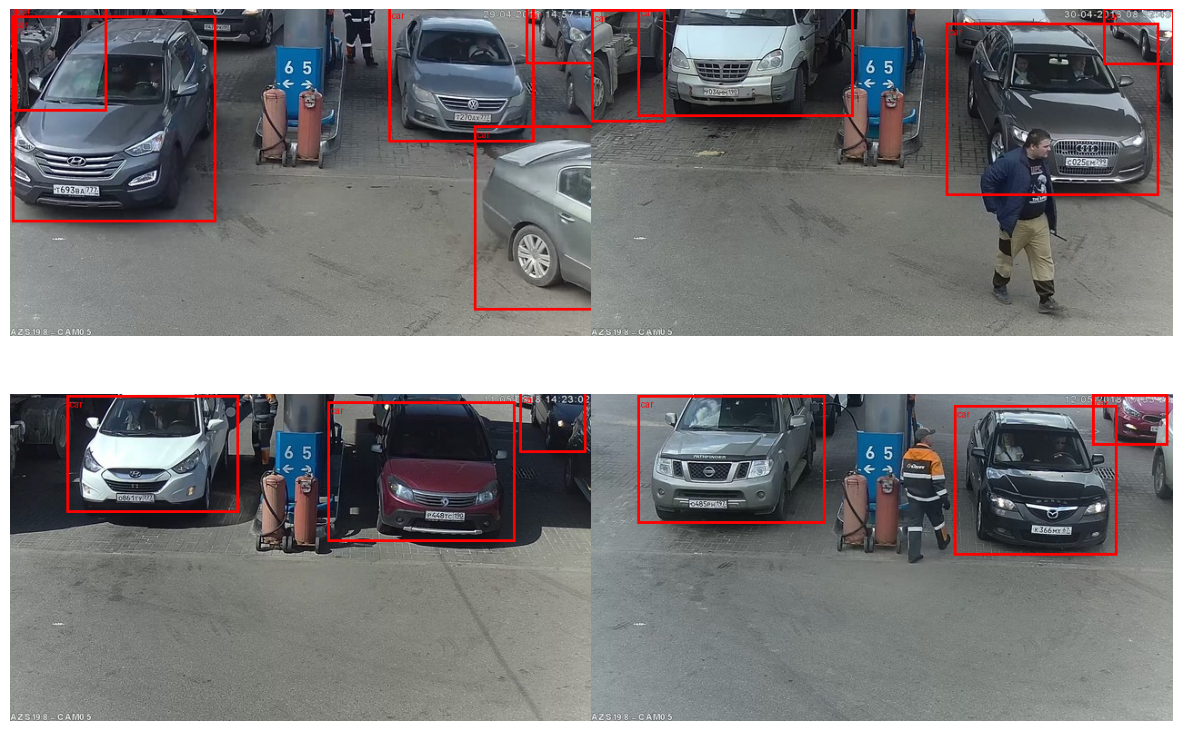

In [26]:
test_image_s = random.sample( glob.glob("dataset/JPEGImages/*.jpg"), 4)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15, 10))

for index, image_filename in enumerate(test_image_s):
    i = index // 2
    j = index % 2
    
    source_image_numpy = cv2.imread(image_filename)
    source_image_numpy = cv2.cvtColor(source_image_numpy, cv2.COLOR_BGR2RGB) 
    
    source_image_numpy = np.transpose(source_image_numpy.astype(np.float32) / 255., axes=[2,0,1])

    source_image_cpu   = torch.from_numpy(source_image_numpy)
    source_image_gpu   = source_image_cpu.cuda()
        
    source_height, source_width = source_image_cpu.shape[1], source_image_cpu.shape[2]
        
    with torch.no_grad():
        loc, conf = model(source_image_gpu.unsqueeze(0))
        conf, loc = F.softmax(conf, dim=2).cpu(), loc.cpu()

    target_box_ss, target_label_ss, target_conf_ss = detect_objects(loc, conf, prior_box, 
                                                                    custom_config['num_classes'], 
                                                                    custom_config['overlap_detect'], 
                                                                    custom_config['conf_threshold'])
    target_box_s, target_label_s, target_conf_s = target_box_ss[0], target_label_ss[0], target_conf_ss[0]
        
    if torch.numel(target_box_s)>0 and torch.numel(target_label_s)>0 and torch.numel(target_conf_s)>0 :
        target_class_s = [VOC_CLASSES[label] for label in target_label_s.tolist() ]
        
        target_image_cpu   = torch.from_numpy(source_image_numpy * 255).to(torch.uint8)
        target_box_s       = target_box_s * torch.as_tensor([[source_width, source_height, source_width, source_height]])

        target_image_cpu   = draw_bounding_boxes(target_image_cpu, target_box_s, labels=target_class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()

    ax[i][j].imshow(target_image_numpy)
    ax[i][j].axis('off')
plt.show()   

## Разработать модель на основе ResNet18

In [34]:
from torchvision.models.resnet import BasicBlock

In [35]:
class ExtraBlock(nn.Module):
    def __init__(self, in_channels=128, hid_channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hid_channels, kernel_size=3, padding=1, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hid_channels, in_channels, kernel_size=1, padding=0, stride=1)
        self.relu2 = nn.ReLU(inplace=True)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        return out


class SSD_ResNet(nn.Module):
    def __init__(self, num_bboxes_s, num_labels = 2):
        super().__init__()

        self.num_bboxes_s = num_bboxes_s
        self.num_labels   = num_labels
        self.used_layer_id_s = [8, 9, 10, 11, 12, 13]

        base_layers       = self._build_base_layers ()
        extra_layers      = self._build_extra_layers()
        self.total_layers = base_layers + extra_layers

        self.conf_layers, self.loc_layers = self._build_conf_loc_layers()

    def _build_base_layers(self):
        backbone_model    = models.resnet18(weights=ResNet18_Weights.DEFAULT)  #False

        base_layers = nn.ModuleList(list(backbone_model.children())[:-3])

        return base_layers
    
    def _build_extra_layers(self):
        extra_layers = []

        downsample = nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(128),
            )

        nn.init.xavier_uniform_(downsample[0].weight)

        ResNetBlock = BasicBlock(256, 128, 1, downsample)
        ResNetBlock2 = BasicBlock(128, 128)

        nn.init.xavier_uniform_(ResNetBlock.conv1.weight)
        nn.init.xavier_uniform_(ResNetBlock.conv2.weight)
        nn.init.xavier_uniform_(ResNetBlock2.conv1.weight)
        nn.init.xavier_uniform_(ResNetBlock2.conv2.weight)

        extra_blocks = [ExtraBlock(128, 64) for _ in range(5)]

        extra_layers = nn.ModuleList( [ResNetBlock, ResNetBlock2] + extra_blocks )

        return extra_layers
    
    def _build_conf_loc_layers(self):
        conf_layers, loc_layers = [], []
        for i, j in enumerate(self.used_layer_id_s):
            conf_layer = nn.Conv2d(self.total_layers[j].conv2.out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
            loc_layer  = nn.Conv2d(self.total_layers[j].conv2.out_channels, self.num_bboxes_s[i] * 4              , kernel_size=3, padding=1)

            nn.init.xavier_uniform_(conf_layer.weight)
            nn.init.zeros_         (conf_layer  .bias)
            nn.init.xavier_uniform_(loc_layer .weight)
            nn.init.zeros_         (loc_layer   .bias)

            conf_layers += [conf_layer]
            loc_layers  += [loc_layer ]

        conf_layers = nn.ModuleList(conf_layers)
        loc_layers  = nn.ModuleList(loc_layers )

        return conf_layers, loc_layers

    def forward(self, x):
        source_s, loc_s, conf_s = [], [], []

        for i, current_layer in enumerate(self.total_layers):
            x = current_layer(x)
            if i in self.used_layer_id_s:
                source_s.append(x)

        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s .append(l(s).permute(0, 2, 3, 1).contiguous())

        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s  = torch.cat([o.view(o.size(0), -1) for o in loc_s ], 1)

        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s  = loc_s .view(loc_s .size(0), -1, 4              )

        return loc_s, conf_s

In [27]:
#create images of size 720x1280

path_img_orig = './dataset/JPEGImages2'
if not os.path.exists(path_img_orig):
    os.makedirs(path_img_orig)

for img_name in os.listdir('./dataset/JPEGImages'):
    source_image_numpy = cv2.imread(os.path.join('./dataset/JPEGImages', img_name))
    new_img = cv2.resize(source_image_numpy, (1280, 720))
    cv2.imwrite(os.path.join('./dataset/JPEGImages2', img_name), new_img)

## Натренировать модель на основе ResNet18

Эту модель я обучал на 2 классах + фон.

In [36]:
#ResNet18

custom_config = {
 'num_classes'  : 3,
 'feature_maps' : [(45, 80), (23, 40), (12, 20), (6, 10), (3, 5), (2, 3)],
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00], #Параметр масштаба боксов
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05], #Параметр масштаба боксов

 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]], #Здесь ваши настройки
 'num_priors'   : [6, 6, 6, 6, 6, 6], #Здесь ваши настройки
 'variance'     : [0.1, 0.2],
 'clip'         :    True,

 'overlap_threshold': 0.5, #Параметр IoU
 'conf_threshold'   : 0.1, #Параметр confidence
 'overlap_detect'   : 0.25,
 'neg_pos_ratio'    :   3, #Параметр hard-negative mining

 'model_name' : 'resnet18'

}

In [57]:
train_annotation_filename = os.path.join(param_s.dataset_root_dir, "ImageSets/Main/trainval.txt" )
test_annotation_filename  = os.path.join(param_s.dataset_root_dir, "ImageSets/Main/test.txt"     )
train_dataloader          = get_train_dataloader(param_s.dataset_root_dir, train_annotation_filename, param_s.batch_size, param_s.num_workers)
test_dataloader           = get_test_dataloader (param_s.dataset_root_dir, test_annotation_filename , param_s.batch_size, param_s.num_workers)

In [58]:
batch = next(iter(test_dataloader))

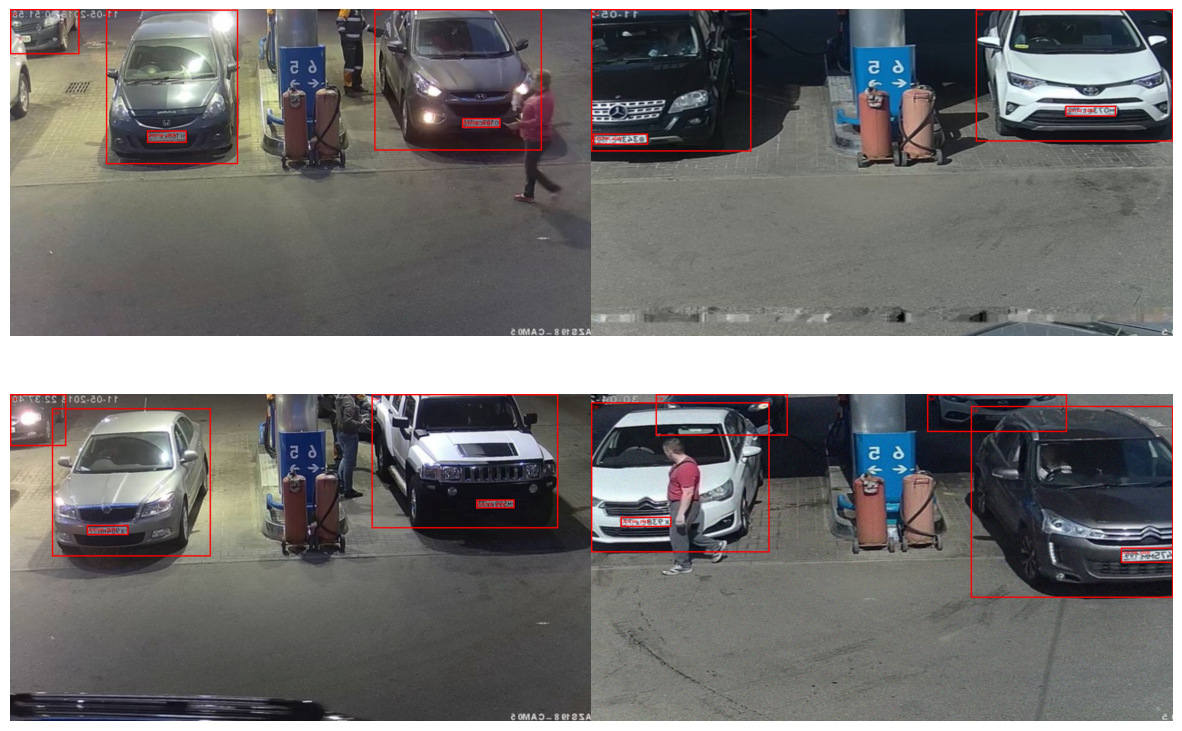

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15, 10))

for i in range(4):
    image_cpu = convert_img_back(batch[0][i])
    box_s = batch[1][i]
    label_s = batch[2][i]
    height, width = image_cpu.shape[1], image_cpu.shape[2]

    if torch.numel(box_s)>0 and torch.numel(label_s)>0:
        class_s = [VOC_CLASSES[label] for label in label_s.tolist()]
        box_s = box_s * torch.as_tensor([[width, height, width, height]])

        target_image_cpu   = draw_bounding_boxes(image_cpu, box_s, labels=class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = image_cpu.permute([1,2,0]).numpy()

    ax[i // 2][i % 2].imshow(target_image_numpy)
    ax[i // 2][i % 2].axis('off')

plt.show()   

In [60]:
model, prior_box, train_loss, eval_loss, train_map, eval_map = train_process(param_s, custom_config, SSD_ResNet, train_dataloader, test_dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.4MB/s]
  5%|▌         | 1/20 [01:24<26:40, 84.24s/it]

epoch[0] | lr 0.00100 | loc_loss [649.39/16.68] | cls_loss [1069.33/28.50] | total_loss [1718.71/45.18] | map [0.0812/0.7342]


 10%|█         | 2/20 [02:42<24:17, 80.99s/it]

epoch[1] | lr 0.00100 | loc_loss [321.39/11.22] | cls_loss [608.99/23.91] | total_loss [930.39/35.12] | map [0.8129/0.8716]


 15%|█▌        | 3/20 [04:01<22:35, 79.74s/it]

epoch[2] | lr 0.00100 | loc_loss [234.49/8.92] | cls_loss [532.81/21.99] | total_loss [767.30/30.90] | map [0.8631/0.8743]


 20%|██        | 4/20 [05:21<21:18, 79.91s/it]

epoch[3] | lr 0.00100 | loc_loss [194.54/7.57] | cls_loss [491.99/20.95] | total_loss [686.53/28.52] | map [0.8825/0.9050]


 25%|██▌       | 5/20 [06:39<19:47, 79.16s/it]

epoch[4] | lr 0.00100 | loc_loss [176.82/6.84] | cls_loss [465.66/21.04] | total_loss [642.48/27.88] | map [0.8826/0.8788]


 30%|███       | 6/20 [07:58<18:31, 79.36s/it]

epoch[5] | lr 0.00100 | loc_loss [152.90/6.78] | cls_loss [433.39/19.55] | total_loss [586.30/26.34] | map [0.8953/0.8796]


 35%|███▌      | 7/20 [09:17<17:09, 79.19s/it]

epoch[6] | lr 0.00100 | loc_loss [144.67/6.35] | cls_loss [421.21/19.88] | total_loss [565.89/26.23] | map [0.9040/0.8957]


 40%|████      | 8/20 [10:38<15:55, 79.60s/it]

epoch[7] | lr 0.00100 | loc_loss [133.06/5.72] | cls_loss [402.58/18.04] | total_loss [535.64/23.75] | map [0.9056/0.9089]


 45%|████▌     | 9/20 [11:56<14:32, 79.32s/it]

epoch[8] | lr 0.00100 | loc_loss [127.19/4.99] | cls_loss [391.18/19.56] | total_loss [518.37/24.55] | map [0.9102/0.8964]


 50%|█████     | 10/20 [13:15<13:11, 79.14s/it]

epoch[9] | lr 0.00020 | loc_loss [120.21/5.43] | cls_loss [382.42/18.54] | total_loss [502.63/23.98] | map [0.9170/0.8824]


 55%|█████▌    | 11/20 [14:35<11:53, 79.27s/it]

epoch[10] | lr 0.00020 | loc_loss [103.13/5.05] | cls_loss [352.84/17.10] | total_loss [455.96/22.15] | map [0.9174/0.9129]


 60%|██████    | 12/20 [15:55<10:35, 79.50s/it]

epoch[11] | lr 0.00020 | loc_loss [98.94/4.71] | cls_loss [344.87/17.39] | total_loss [443.82/22.09] | map [0.9217/0.9074]


 65%|██████▌   | 13/20 [17:16<09:20, 80.01s/it]

epoch[12] | lr 0.00020 | loc_loss [96.71/4.25] | cls_loss [340.36/15.92] | total_loss [437.07/20.17] | map [0.9220/0.9121]


 70%|███████   | 14/20 [18:36<07:59, 79.89s/it]

epoch[13] | lr 0.00020 | loc_loss [94.27/4.86] | cls_loss [333.80/17.52] | total_loss [428.07/22.38] | map [0.9223/0.9028]


 75%|███████▌  | 15/20 [19:57<06:41, 80.29s/it]

epoch[14] | lr 0.00020 | loc_loss [94.99/4.92] | cls_loss [335.39/17.10] | total_loss [430.39/22.02] | map [0.9209/0.9293]


 80%|████████  | 16/20 [21:16<05:20, 80.11s/it]

epoch[15] | lr 0.00020 | loc_loss [94.24/4.75] | cls_loss [333.25/18.18] | total_loss [427.48/22.93] | map [0.9216/0.9299]


 85%|████████▌ | 17/20 [22:37<04:00, 80.28s/it]

epoch[16] | lr 0.00020 | loc_loss [92.72/4.56] | cls_loss [331.32/17.33] | total_loss [424.04/21.89] | map [0.9206/0.9142]


 90%|█████████ | 18/20 [23:58<02:40, 80.35s/it]

epoch[17] | lr 0.00020 | loc_loss [90.61/4.87] | cls_loss [324.80/17.97] | total_loss [415.41/22.84] | map [0.9237/0.9010]


 95%|█████████▌| 19/20 [25:19<01:20, 80.60s/it]

epoch[18] | lr 0.00020 | loc_loss [91.19/4.23] | cls_loss [324.90/16.24] | total_loss [416.09/20.47] | map [0.9274/0.9297]


100%|██████████| 20/20 [26:39<00:00, 79.99s/it]

epoch[19] | lr 0.00004 | loc_loss [91.39/4.63] | cls_loss [322.28/16.76] | total_loss [413.68/21.40] | map [0.9244/0.9150]


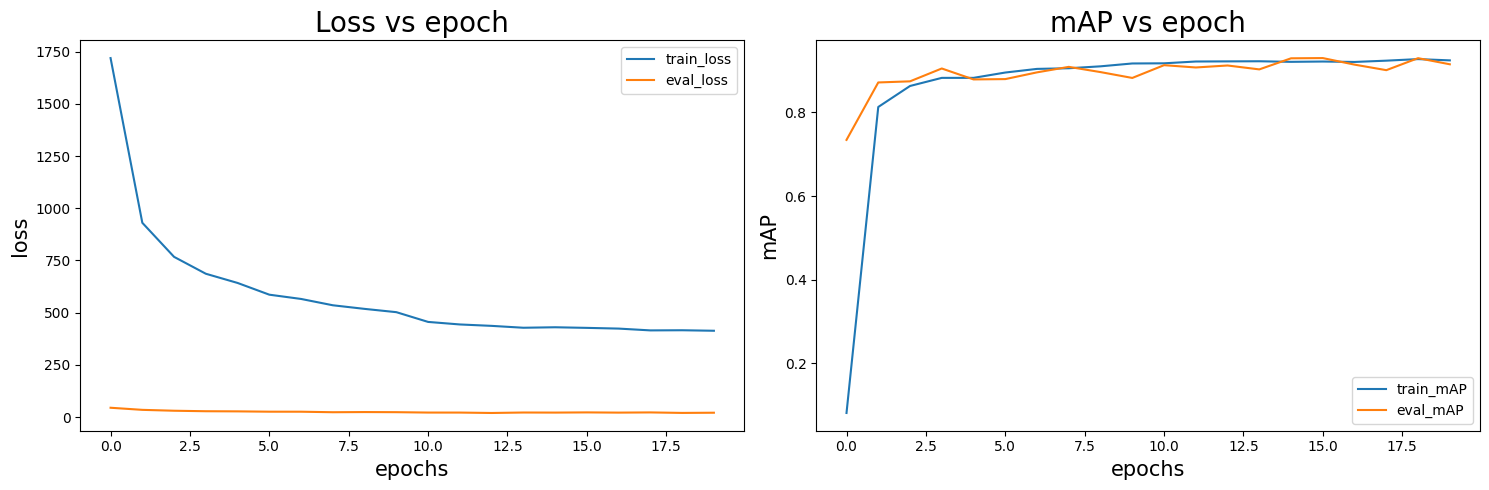

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_loss, label="train_loss")
axes[0].plot(eval_loss, label="eval_loss")
axes[0].legend()
axes[0].set_title("Loss vs epoch", fontsize=20)
axes[0].set_xlabel("epochs", fontsize=15)
axes[0].set_ylabel("loss", fontsize=15)

axes[1].plot(train_map, label="train_mAP")
axes[1].plot(eval_map, label="eval_mAP")
axes[1].legend()
axes[1].set_title("mAP vs epoch", fontsize=20)
axes[1].set_xlabel("epochs", fontsize=15)
axes[1].set_ylabel("mAP", fontsize=15)

plt.tight_layout()
plt.show()

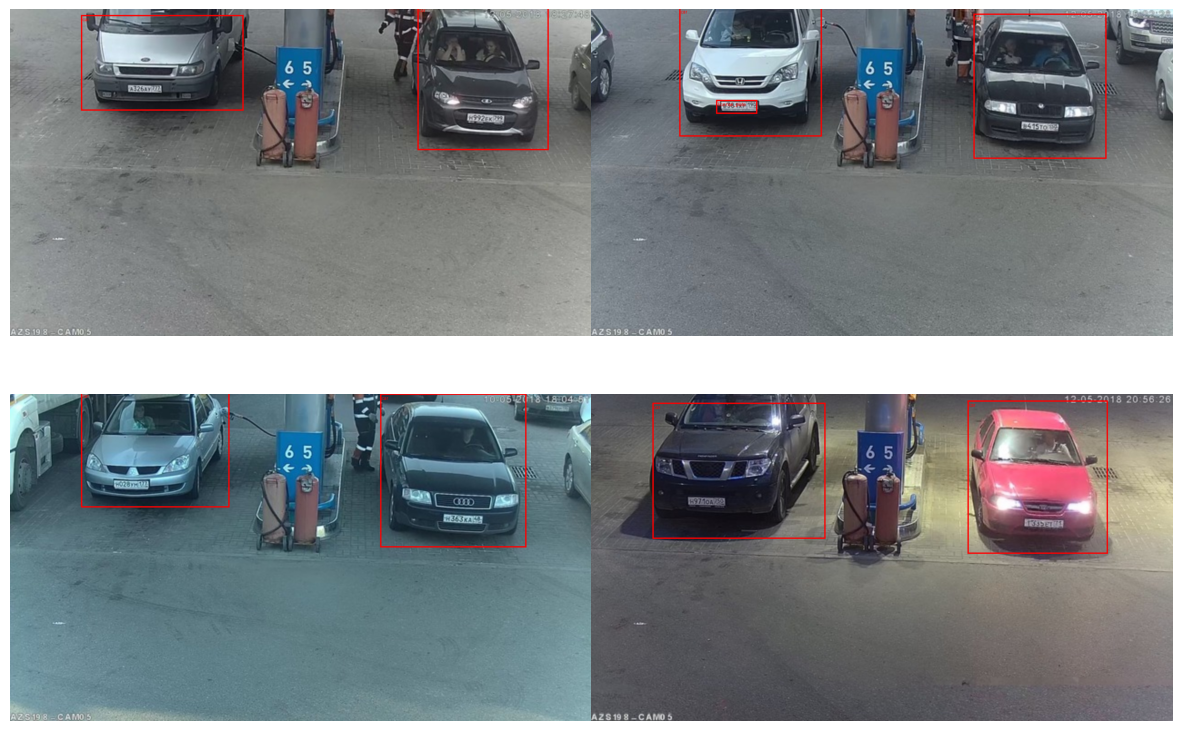

In [67]:
test_image_s = random.sample( glob.glob("dataset/JPEGImages2/*.jpg"), 4)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15, 10))

for index, image_filename in enumerate(test_image_s):
    i = index // 2
    j = index % 2
    
    source_image_numpy = cv2.imread(image_filename)
    source_image_numpy = cv2.cvtColor(source_image_numpy, cv2.COLOR_BGR2RGB) 
    
    source_image_numpy = np.transpose(source_image_numpy.astype(np.float32) / 255., axes=[2,0,1])

    source_image_cpu   = torch.from_numpy(source_image_numpy)
    source_image_gpu   = source_image_cpu.cuda()
        
    source_height, source_width = source_image_cpu.shape[1], source_image_cpu.shape[2]
        
    with torch.no_grad():
        loc, conf = model(source_image_gpu.unsqueeze(0))
        conf, loc = F.softmax(conf, dim=2).cpu(), loc.cpu()

    target_box_ss, target_label_ss, target_conf_ss = detect_objects(loc, conf, prior_box, 
                                                                    custom_config['num_classes'], 
                                                                    custom_config['overlap_detect'], 
                                                                    custom_config['conf_threshold'])
    target_box_s, target_label_s, target_conf_s = target_box_ss[0], target_label_ss[0], target_conf_ss[0]
        
    if torch.numel(target_box_s)>0 and torch.numel(target_label_s)>0 and torch.numel(target_conf_s)>0 :
        target_class_s = [VOC_CLASSES[label] for label in target_label_s.tolist() ]
        
        target_image_cpu   = torch.from_numpy(source_image_numpy * 255).to(torch.uint8)
        target_box_s       = target_box_s * torch.as_tensor([[source_width, source_height, source_width, source_height]])

        target_image_cpu   = draw_bounding_boxes(target_image_cpu, target_box_s, labels=target_class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()

    ax[i][j].imshow(target_image_numpy)
    ax[i][j].axis('off')
plt.show()   

## (БОНУС) Добавить разнообразные аугментации изображений в классе Dataset. Провести эксперименты и продемонстрировать метрику mAP.

Попробуем применить strong transform из utils к фоткам.

In [ ]:
train_dataloader  = get_train_dataloader(param_s.dataset_root_dir, train_annotation_filename, param_s.batch_size, param_s.num_workers, strong_transform)
test_dataloader   = get_test_dataloader (param_s.dataset_root_dir, test_annotation_filename , param_s.batch_size, param_s.num_workers)

In [69]:
model2, prior_box2, train_loss2, eval_loss2, train_map2, eval_map2 = train_process(param_s, custom_config, SSD_ResNet, train_dataloader, test_dataloader)

  5%|▌         | 1/20 [01:29<28:29, 89.96s/it]

epoch[0] | lr 0.00100 | loc_loss [647.16/16.77] | cls_loss [1067.48/28.46] | total_loss [1714.63/45.23] | map [0.0828/0.7232]


 10%|█         | 2/20 [02:52<25:36, 85.36s/it]

epoch[1] | lr 0.00100 | loc_loss [320.12/11.11] | cls_loss [609.30/23.81] | total_loss [929.41/34.92] | map [0.8153/0.8614]


 15%|█▌        | 3/20 [04:14<23:49, 84.10s/it]

epoch[2] | lr 0.00100 | loc_loss [233.33/8.98] | cls_loss [531.28/22.10] | total_loss [764.61/31.08] | map [0.8651/0.8785]


 20%|██        | 4/20 [05:43<22:56, 86.01s/it]

epoch[3] | lr 0.00100 | loc_loss [193.68/7.36] | cls_loss [490.67/20.90] | total_loss [684.35/28.26] | map [0.8806/0.8896]


 25%|██▌       | 5/20 [07:10<21:34, 86.28s/it]

epoch[4] | lr 0.00100 | loc_loss [176.32/6.82] | cls_loss [466.81/20.48] | total_loss [643.13/27.30] | map [0.8894/0.8938]


 30%|███       | 6/20 [08:47<20:57, 89.83s/it]

epoch[5] | lr 0.00100 | loc_loss [152.84/6.72] | cls_loss [434.76/19.62] | total_loss [587.60/26.33] | map [0.8969/0.9006]


 35%|███▌      | 7/20 [10:15<19:19, 89.20s/it]

epoch[6] | lr 0.00100 | loc_loss [145.44/6.20] | cls_loss [422.05/19.79] | total_loss [567.50/25.99] | map [0.9059/0.8782]


 40%|████      | 8/20 [11:43<17:47, 88.99s/it]

epoch[7] | lr 0.00100 | loc_loss [132.91/5.69] | cls_loss [403.19/18.19] | total_loss [536.10/23.88] | map [0.9102/0.9148]


 45%|████▌     | 9/20 [13:09<16:06, 87.90s/it]

epoch[8] | lr 0.00100 | loc_loss [127.27/5.02] | cls_loss [392.97/19.18] | total_loss [520.24/24.20] | map [0.9162/0.8975]


 50%|█████     | 10/20 [14:37<14:40, 88.01s/it]

epoch[9] | lr 0.00020 | loc_loss [120.47/5.51] | cls_loss [382.62/18.41] | total_loss [503.09/23.92] | map [0.9166/0.8980]


 55%|█████▌    | 11/20 [15:59<12:56, 86.26s/it]

epoch[10] | lr 0.00020 | loc_loss [103.14/5.00] | cls_loss [354.21/17.04] | total_loss [457.35/22.05] | map [0.9203/0.9078]


 60%|██████    | 12/20 [17:21<11:19, 84.99s/it]

epoch[11] | lr 0.00020 | loc_loss [98.70/4.70] | cls_loss [345.06/16.97] | total_loss [443.75/21.67] | map [0.9234/0.9146]


 65%|██████▌   | 13/20 [18:43<09:48, 84.03s/it]

epoch[12] | lr 0.00020 | loc_loss [97.10/4.20] | cls_loss [341.37/15.78] | total_loss [438.48/19.98] | map [0.9203/0.9167]


 70%|███████   | 14/20 [20:04<08:18, 83.15s/it]

epoch[13] | lr 0.00020 | loc_loss [94.33/4.81] | cls_loss [335.34/17.30] | total_loss [429.67/22.10] | map [0.9272/0.9074]


 75%|███████▌  | 15/20 [21:25<06:52, 82.51s/it]

epoch[14] | lr 0.00020 | loc_loss [94.80/4.93] | cls_loss [336.30/16.91] | total_loss [431.10/21.84] | map [0.9260/0.9275]


 80%|████████  | 16/20 [22:46<05:28, 82.01s/it]

epoch[15] | lr 0.00020 | loc_loss [94.02/4.75] | cls_loss [334.43/18.24] | total_loss [428.45/22.99] | map [0.9249/0.9252]


 85%|████████▌ | 17/20 [24:08<04:05, 82.00s/it]

epoch[16] | lr 0.00020 | loc_loss [92.79/4.55] | cls_loss [332.50/17.14] | total_loss [425.29/21.68] | map [0.9238/0.9120]


 90%|█████████ | 18/20 [25:31<02:44, 82.34s/it]

epoch[17] | lr 0.00020 | loc_loss [90.65/4.87] | cls_loss [326.48/17.39] | total_loss [417.13/22.26] | map [0.9286/0.9048]


 95%|█████████▌| 19/20 [26:54<01:22, 82.61s/it]

epoch[18] | lr 0.00020 | loc_loss [91.30/4.20] | cls_loss [325.80/16.08] | total_loss [417.11/20.28] | map [0.9263/0.9296]


100%|██████████| 20/20 [28:16<00:00, 84.82s/it]

epoch[19] | lr 0.00004 | loc_loss [91.37/4.59] | cls_loss [322.20/16.64] | total_loss [413.57/21.23] | map [0.9254/0.9119]


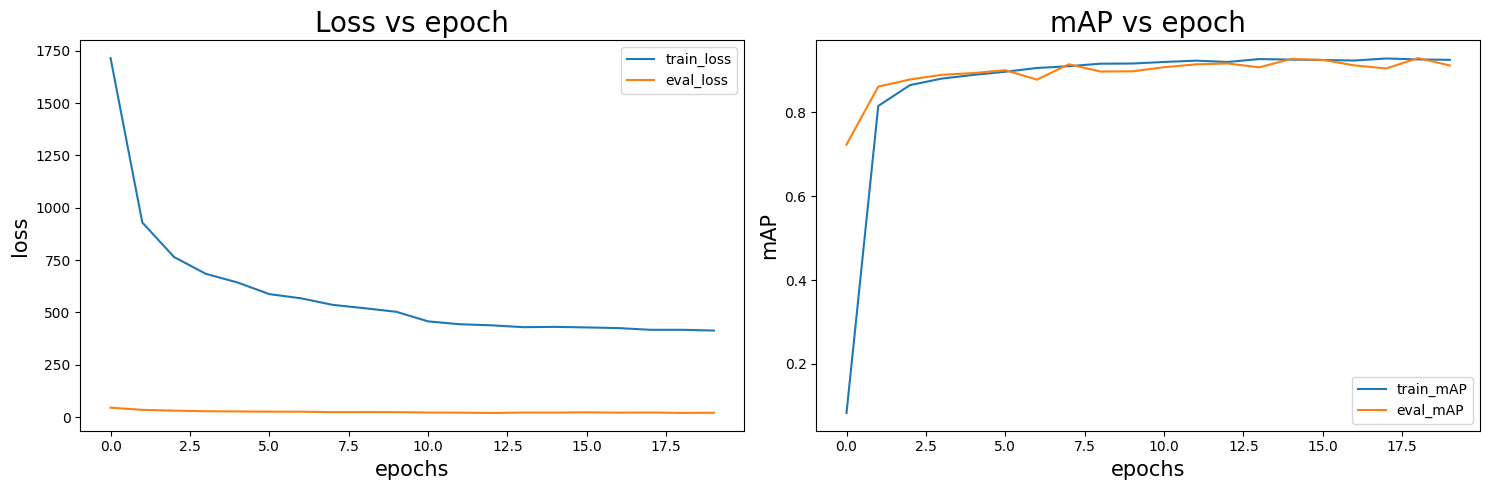

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_loss2, label="train_loss")
axes[0].plot(eval_loss2, label="eval_loss")
axes[0].legend()
axes[0].set_title("Loss vs epoch", fontsize=20)
axes[0].set_xlabel("epochs", fontsize=15)
axes[0].set_ylabel("loss", fontsize=15)

axes[1].plot(train_map2, label="train_mAP")
axes[1].plot(eval_map2, label="eval_mAP")
axes[1].legend()
axes[1].set_title("mAP vs epoch", fontsize=20)
axes[1].set_xlabel("epochs", fontsize=15)
axes[1].set_ylabel("mAP", fontsize=15)

plt.tight_layout()
plt.show()

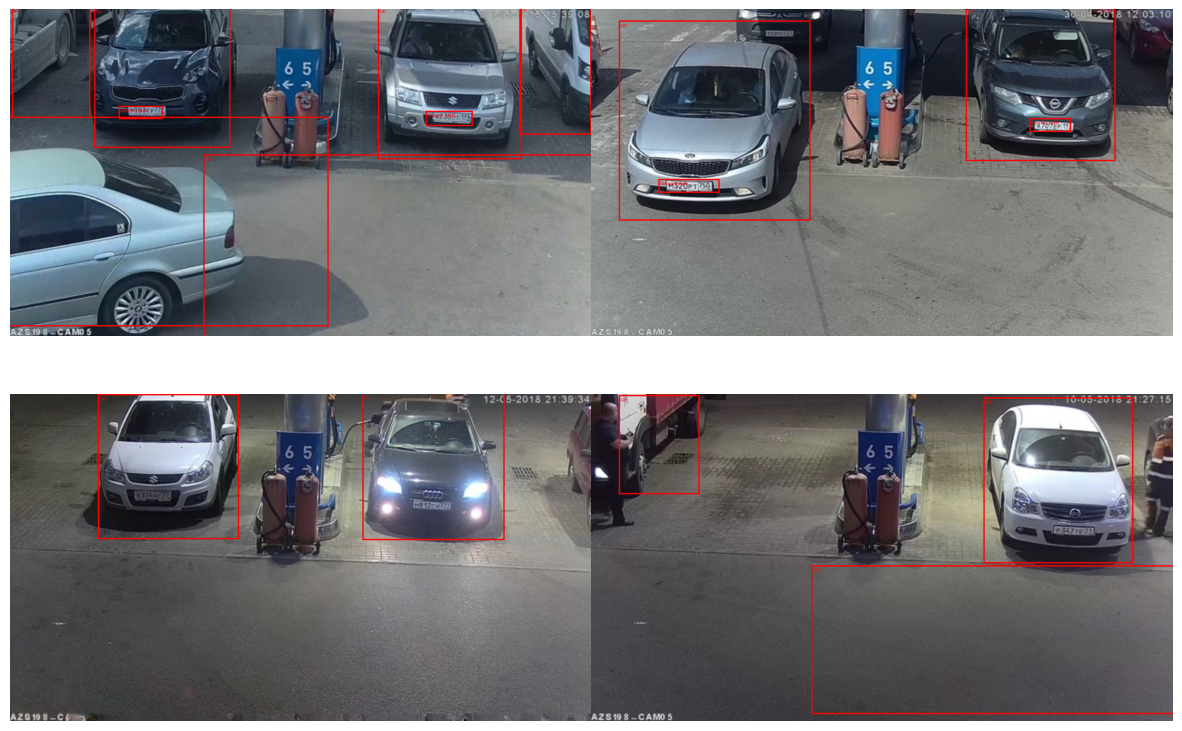

In [71]:
test_image_s = random.sample( glob.glob("dataset/JPEGImages2/*.jpg"), 4)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15, 10))

for index, image_filename in enumerate(test_image_s):
    i = index // 2
    j = index % 2
    
    source_image_numpy = cv2.imread(image_filename)
    source_image_numpy = cv2.cvtColor(source_image_numpy, cv2.COLOR_BGR2RGB) 
    
    source_image_numpy = np.transpose(source_image_numpy.astype(np.float32) / 255., axes=[2,0,1])

    source_image_cpu   = torch.from_numpy(source_image_numpy)
    source_image_gpu   = source_image_cpu.cuda()
        
    source_height, source_width = source_image_cpu.shape[1], source_image_cpu.shape[2]
        
    with torch.no_grad():
        loc, conf = model2(source_image_gpu.unsqueeze(0))
        conf, loc = F.softmax(conf, dim=2).cpu(), loc.cpu()

    target_box_ss, target_label_ss, target_conf_ss = detect_objects(loc, conf, prior_box2, 
                                                                    custom_config['num_classes'], 
                                                                    custom_config['overlap_detect'], 
                                                                    custom_config['conf_threshold'])
    target_box_s, target_label_s, target_conf_s = target_box_ss[0], target_label_ss[0], target_conf_ss[0]
        
    if torch.numel(target_box_s)>0 and torch.numel(target_label_s)>0 and torch.numel(target_conf_s)>0 :
        target_class_s = [VOC_CLASSES[label] for label in target_label_s.tolist() ]
        
        target_image_cpu   = torch.from_numpy(source_image_numpy * 255).to(torch.uint8)
        target_box_s       = target_box_s * torch.as_tensor([[source_width, source_height, source_width, source_height]])

        target_image_cpu   = draw_bounding_boxes(target_image_cpu, target_box_s, labels=target_class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()

    ax[i][j].imshow(target_image_numpy)
    ax[i][j].axis('off')
plt.show()   

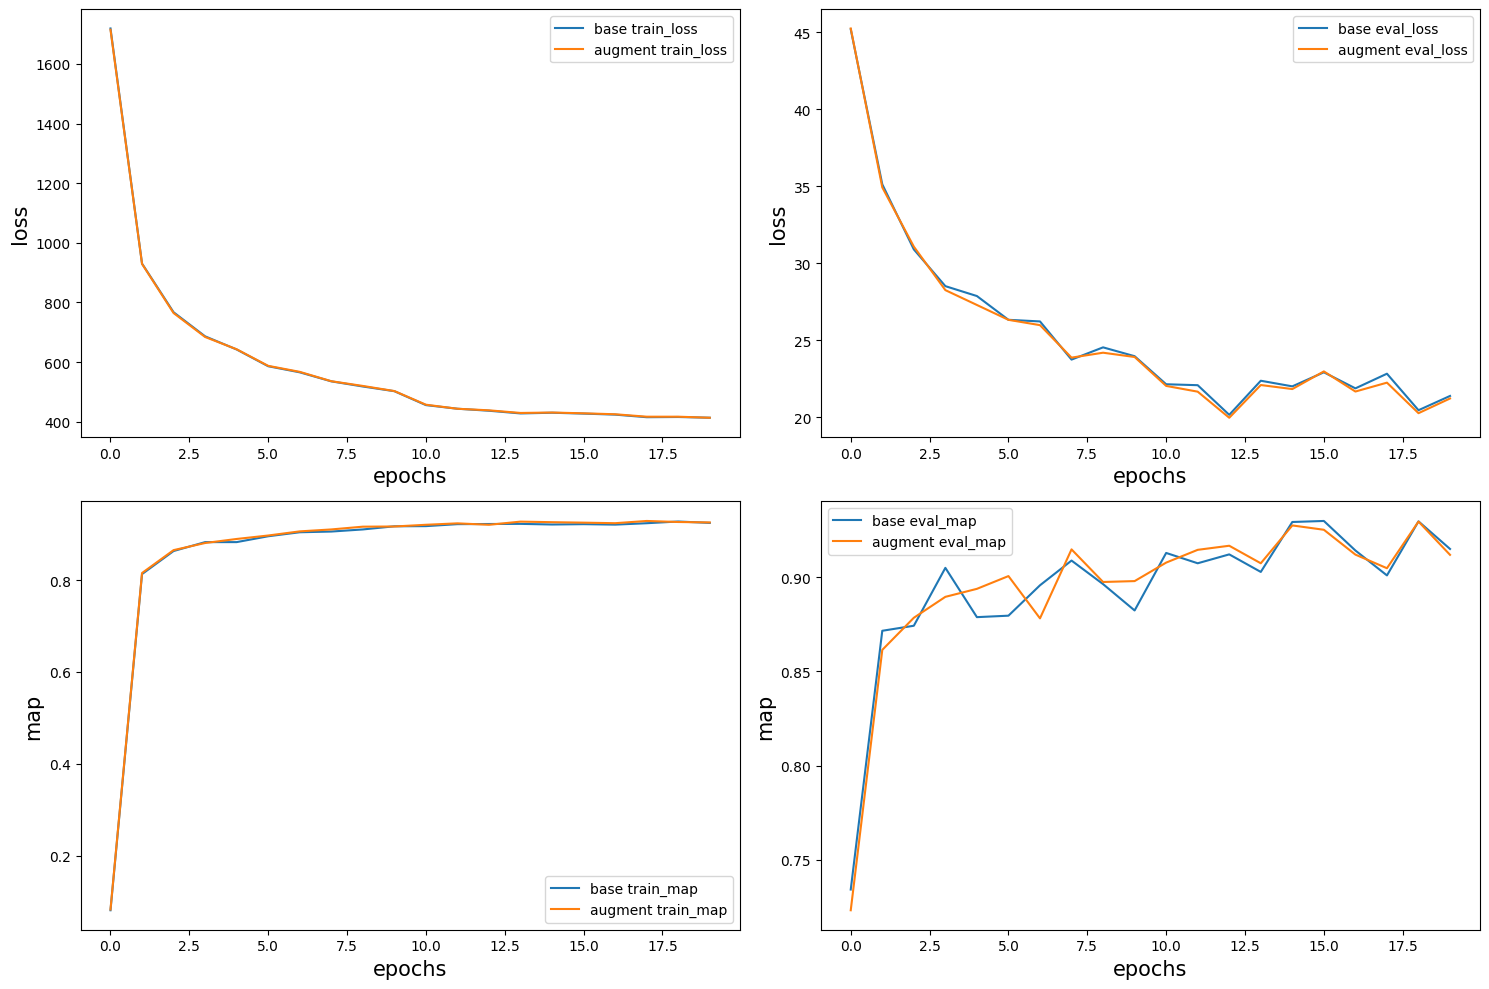

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
light_vals = [train_loss, eval_loss, train_map, eval_map]
light_names = ["base train_loss", "base eval_loss", "base train_map", "base eval_map"]
strong_vals = [train_loss2, eval_loss2, train_map2, eval_map2]
strong_names = ["augment train_loss", "augment eval_loss", "augment train_map", "augment eval_map"]
ylabels_names = ["loss", "loss", "map", "map"]

for i in range(4):
    axes[i // 2][i % 2].plot(light_vals[i], label=light_names[i])
    axes[i // 2][i % 2].plot(strong_vals[i], label=strong_names[i])
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_xlabel("epochs", fontsize=15)
    axes[i // 2][i % 2].set_ylabel(ylabels_names[i], fontsize=15)

plt.tight_layout()
plt.show()

По графикам видно, что аугментация не дала существенных различий,разве что лосс на обучении чуть меньше, ну и на валидации метрика mAP будто более стабильная.